In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join("./", "..", ".."))

In [2]:
# data_path = './../../Data/diabetes/'
# X = pd.read_csv(data_path + 'diabetes.csv', usecols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age']).to_numpy()

# y = pd.read_csv(data_path + 'diabetes.csv', usecols = ['Outcome']).to_numpy()

# X = X - np.min(X, axis = 0)
# X = X / np.max(X, axis = 0)


# np.savetxt(data_path + "X.tsv", X, delimiter="\t")
# np.savetxt(data_path + "y.tsv", y, delimiter="\t")



In [2]:
config_path = './../../configs/vae.json'
import json
from types import SimpleNamespace
config = SimpleNamespace(**json.load(open(config_path, 'r')))

In [3]:
config

namespace(features_path='./Reproduction/Housing/Data/X.tsv',
          labels_path='./Reproduction/Housing/Data/y.tsv',
          model_dir='./Models/',
          batch_size=128,
          min_epochs=200,
          stopping_epochs=25,
          tol=0.001,
          eval_freq=1,
          lr=0.001)

In [4]:
data_path = './../../Data/diabetes/diabetes.csv'
config.features_path = data_path + "X.tsv"
config.labels_path = data_path + "y.tsv"
config.model_dir = './../../Models'
config.dataset = "diabetes"

In [5]:
from Model import *

In [6]:
model = Model.Initialize('vae', None, pretrained_path='./../../Models/scvis_diabetes.pt')

Loading the pretrained model...


In [7]:
# import pandas as pd
x = pd.read_csv('./../../Data/diabetes/X.tsv', sep="\t").to_numpy()
y = pd.read_csv('./../../Data/diabetes/y.tsv', sep="\t").to_numpy().tolist()

In [8]:
data_rep = model.Encode(x)

In [11]:
colors = []
for label in y:
    if label == 1.0:
        colors.append('red')
    else:
        colors.append('blue')

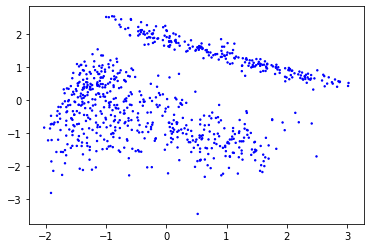

In [12]:
import matplotlib.pyplot as plt
plt.scatter(data_rep[:,0], data_rep[:,1], c=colors, s=2)

In [13]:
from sklearn.cluster import KMeans
num_clusters = 3

kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)

In [14]:
from eldr.plotter.myplot import *
means, centers, indices = plot_groups(x, data_rep.numpy(), num_clusters, kmeans.labels_, name = "./synth-rep.png")

In [19]:
# Evaluate the explanations
from eldr.explain.explain_cs_copy import *
from eldr.plotter.myplot import *
k = 5
epsilon = 0.34
import torch
feature_names = list(pd.read_csv('./../../Data/diabetes/diabetes.csv').columns)[:-1]

deltas_ = np.load("./deltas/deltas" + str(k) + ".npy")
np.set_printoptions(suppress=True)

Explainer = Explain(model, means, centers, dist='l2')

a, b = Explainer.metrics(torch.tensor(x), indices, torch.from_numpy(deltas_), epsilon, k = k)

plot_metrics(a, b, name = "diabetes-metrics.png")

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 1, k = k, num_points = 25, name = "diabetes-0to1.png", feature_names = feature_names)

plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 0, k = k,  num_points = 25, name = "diabetes-1to0.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 0, 2, k = k, num_points = 25, name = "diabetes-0to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 1, 2, k = k,  num_points = 25, name = "diabetes-1to2.png", feature_names = feature_names)
plot_explanation(model, x, data_rep, indices, deltas_, a, b, 2, 1, k = k,  num_points = 25, name = "diabetes-2to1.png", feature_names = feature_names)

./../../eldr/plotter/myplot.py:105: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  ax.cax.colorbar(im)
/home2/tirthankar/miniconda3_1/envs/rajeev3/lib/python3.7/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


In [16]:
out = np.loadtxt("out.csv", delimiter = ",")
    
print(out)

[[ 1.          0.76350439  0.83801066  0.75791002  0.82750543]
 [ 3.          0.8010234   0.88275895  0.76272148  0.85335395]
 [ 5.          0.79991329  0.8796183   0.77326044  0.86664531]
 [ 7.          0.80347073  0.8758975   0.77511383  0.87596171]
 [ 9.          0.79938259  0.8689583   0.77854456  0.87405911]
 [11.          0.80417143  0.88537628  0.77854456  0.87405911]
 [13.          0.80447529  0.87912303  0.77854456  0.87405911]]


#### Classification

In [20]:
class_data = []
class_label = []
for i, ind in enumerate(indices):
    class_data.extend(x[ind])
    class_label.extend([i]*len(ind))

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
X = class_data
y = class_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=0)
clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)

In [22]:
estimators = clf.estimators_

Class  0
Pregnancies , Score: 0.0039
Glucose , Score: 0.0013
BloodPressure , Score: 0.0005
SkinThickness , Score: 0.3095
Insulin , Score: 0.0180
BMI , Score: -0.0003
DiabetesPedigreeFunction , Score: 0.0000
Age , Score: 0.0112


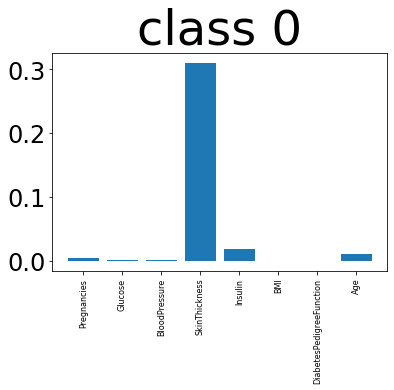

Class  1
Pregnancies , Score: 0.0704
Glucose , Score: 0.0117
BloodPressure , Score: 0.0034
SkinThickness , Score: -0.0021
Insulin , Score: -0.0008
BMI , Score: 0.0037
DiabetesPedigreeFunction , Score: 0.0021
Age , Score: 0.1677


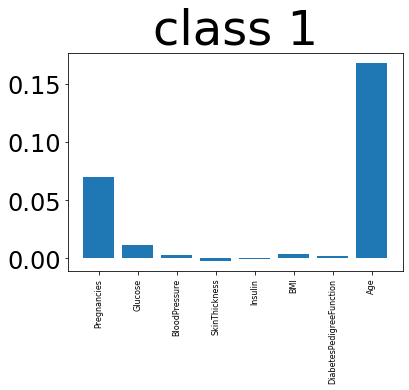

Class  2
Pregnancies , Score: 0.0052
Glucose , Score: -0.0013
BloodPressure , Score: 0.0018
SkinThickness , Score: -0.2980
Insulin , Score: -0.0216
BMI , Score: -0.0021
DiabetesPedigreeFunction , Score: 0.0026
Age , Score: 0.0047


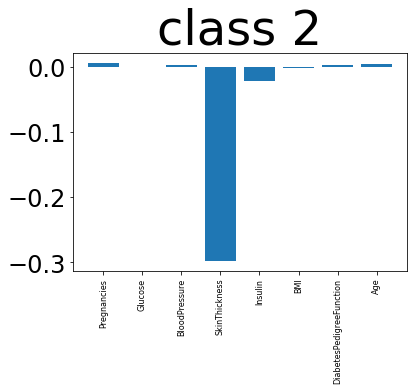

In [35]:
from sklearn.inspection import permutation_importance
for i, clf in enumerate(estimators):
    print("Class ", i)
    results = permutation_importance(clf, X, y, scoring='accuracy')
    importance = results.importances_mean
    for feature_name, v in zip(feature_names, importance):
        print('{} , Score: {:.4f}' .format(feature_name,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.title("class " + str(i))
    plt.xticks(range(len(feature_names)), labels=feature_names, rotation=90, fontsize=8)
    plt.show()

In [ ]:
estimators